In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [6]:
import os
from PIL import Image

# Path to your dataset
dataset_path = 'garbage-dataset'

# Check if the dataset path exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"The dataset path '{dataset_path}' does not exist.")

print("🔍 Scanning for corrupted or unreadable images...")

# List to store bad image paths
bad_images = []

# Loop through all classes/folders
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Will raise an exception if corrupt
            except (IOError, SyntaxError, ValueError) as e:
                bad_images.append(img_path)

# Print number of bad images found
print(f"🗑️ Found {len(bad_images)} corrupted images.")

# Optionally remove them
for bad_img in bad_images:
    os.remove(bad_img)

print("✅ Cleaning complete. Damaged images removed.")


🔍 Scanning for corrupted or unreadable images...
🗑️ Found 0 corrupted images.
✅ Cleaning complete. Damaged images removed.


In [7]:
# Bar chart of image distribution per class
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Number of Images per Waste Category')
plt.xlabel('Waste Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [8]:
# Show one random image per class
plt.figure(figsize=(14, 10))

for i, class_name in enumerate(sorted(class_counts.keys())):
    class_dir = os.path.join(dataset_path, class_name)
    sample_img = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, sample_img)

    img = mpimg.imread(img_path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data generator with augmentation for training and just rescaling for validation
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize images to [0,1]
    validation_split=0.2,      # 80% for training, 20% for validation
    rotation_range=15,         # Data augmentation
    zoom_range=0.1,
    horizontal_flip=True
)

# Training data
train_data = datagen.flow_from_directory(
    directory=dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data
val_data = datagen.flow_from_directory(
    directory=dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Display class labels
print("🔎 Class Indices:", train_data.class_indices)


Found 15813 images belonging to 10 classes.
Found 3949 images belonging to 10 classes.
🔎 Class Indices: {'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load base model without top layers
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers (for transfer learning)
base_model.trainable = False

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

# Combine base + head
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 632s 1s/step - accuracy: 0.7241 - loss: 0.8636 - val_accuracy: 0.8830 - val_loss: 0.3544 - learning_rate: 0.0010
Epoch 2/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 400s 808ms/step - accuracy: 0.8750 - loss: 0.3819 - val_accuracy: 0.9040 - val_loss: 0.2986 - learning_rate: 0.0010
Epoch 3/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 349s 704ms/step - accuracy: 0.8955 - loss: 0.3116 - val_accuracy: 0.8985 - val_loss: 0.2961 - learning_rate: 0.0010
Epoch 4/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 357s 722ms/step - accuracy: 0.9026 - loss: 0.2856 - val_accuracy: 0.9119 - val_loss: 0.2629 - learning_rate: 0.0010
Epoch 5/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 356s 719ms/step - accuracy: 0.9001 - loss: 0.2889 - val_accuracy: 0.9124 - val_loss: 0.2633 - learning_rate: 0.0010
Epoch 6/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 583s 1s/step - accuracy: 0.9156 - loss: 0.2459 - val_accuracy: 0.9066 - val_loss: 0.2816 - learning_rate: 0.0010
Epoch 7/25
495/495 ━━━━━━━━━━━━━━━━━━━━ 1118s 2s/step - accuracy: 0.91

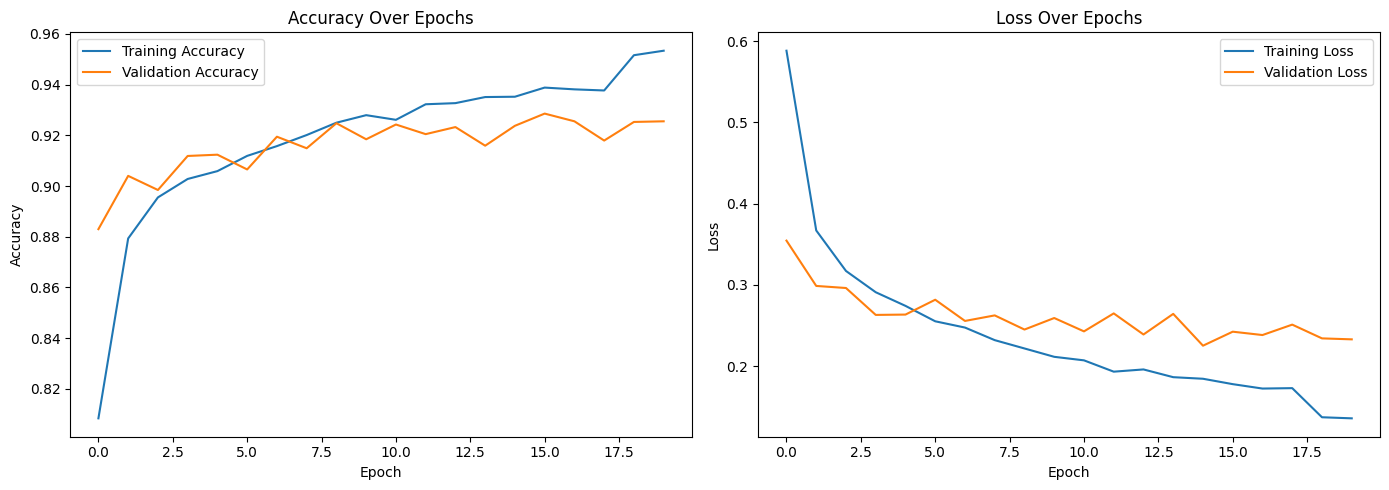

In [14]:
import matplotlib.pyplot as plt

# Replace with your actual history object: history.history
plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on validation set
val_steps = val_data.samples // val_data.batch_size + 1
y_pred = model.predict(val_data, steps=val_steps)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes[:len(y_pred_classes)]

# Class labels
labels = list(val_data.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



124/124 ━━━━━━━━━━━━━━━━━━━━ 67s 530ms/step


In [16]:
from sklearn.metrics import classification_report

# Print the classification report directly in the output cell
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=val_data.class_indices.keys()
))


              precision    recall  f1-score   support

     battery       0.07      0.07      0.07       188
  biological       0.05      0.05      0.05       199
   cardboard       0.07      0.08      0.08       365
     clothes       0.27      0.27      0.27      1065
       glass       0.15      0.16      0.16       612
       metal       0.04      0.04      0.04       204
       paper       0.08      0.08      0.08       336
     plastic       0.10      0.10      0.10       396
       shoes       0.09      0.09      0.09       395
       trash       0.05      0.04      0.05       189

    accuracy                           0.14      3949
   macro avg       0.10      0.10      0.10      3949
weighted avg       0.14      0.14      0.14      3949



In [17]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
import numpy as np

# 🔹 Step 1: Unfreeze last 50 layers for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# 🔹 Step 2: Recompute class weights based on training data
class_indices = train_data.class_indices            # {'battery': 0, 'biological': 1, ...}
labels = train_data.classes                         # actual class index per image
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(zip(np.unique(labels), class_weights_array))

# 🔹 Step 3: Compile model with smaller learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 🔹 Step 4: Re-train the model with fine-tuning and class weights
history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,  # You can adjust this
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]  # if already defined
)


Epoch 1/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 456s 907ms/step - accuracy: 0.8106 - loss: 0.6809 - val_accuracy: 0.9243 - val_loss: 0.2538 - learning_rate: 1.0000e-05
Epoch 2/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 492s 995ms/step - accuracy: 0.8790 - loss: 0.3990 - val_accuracy: 0.9180 - val_loss: 0.2666 - learning_rate: 1.0000e-05
Epoch 3/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 476s 962ms/step - accuracy: 0.8991 - loss: 0.3131 - val_accuracy: 0.9250 - val_loss: 0.2645 - learning_rate: 1.0000e-05
Epoch 4/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 463s 935ms/step - accuracy: 0.9106 - loss: 0.2689 - val_accuracy: 0.9205 - val_loss: 0.2639 - learning_rate: 1.0000e-05
Epoch 5/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 453s 916ms/step - accuracy: 0.9173 - loss: 0.2479 - val_accuracy: 0.9205 - val_loss: 0.2534 - learning_rate: 2.0000e-06
Epoch 6/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 472s 953ms/step - accuracy: 0.9135 - loss: 0.2540 - val_accuracy: 0.9288 - val_loss: 0.2413 - learning_rate: 2.0000e-06
Epoch 7/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 

124/124 ━━━━━━━━━━━━━━━━━━━━ 66s 523ms/step
📊 Classification Report:

              precision    recall  f1-score   support

     battery       0.04      0.04      0.04       188
  biological       0.03      0.03      0.03       199
   cardboard       0.09      0.10      0.09       365
     clothes       0.30      0.29      0.30      1065
       glass       0.16      0.16      0.16       612
       metal       0.03      0.04      0.04       204
       paper       0.12      0.12      0.12       336
     plastic       0.11      0.10      0.10       396
       shoes       0.09      0.09      0.09       395
       trash       0.08      0.09      0.09       189

    accuracy                           0.15      3949
   macro avg       0.11      0.11      0.11      3949
weighted avg       0.15      0.15      0.15      3949



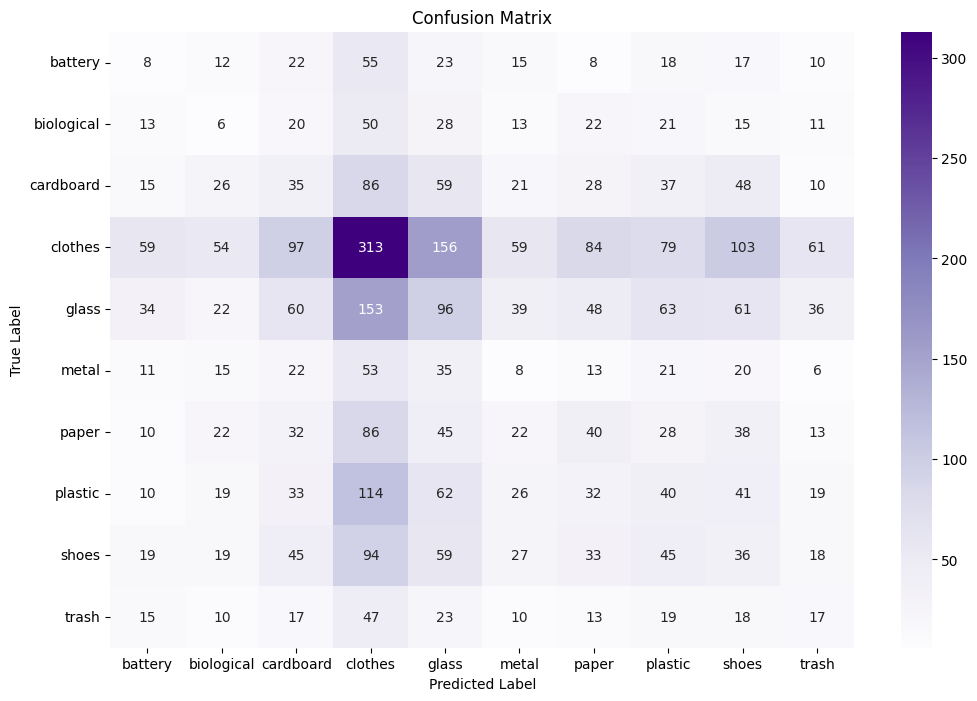

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 🔹 Step 1: Predict labels for validation set
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_data.classes

# 🔹 Step 2: Print Classification Report
class_labels = list(val_data.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels, digits=2)
print("📊 Classification Report:\n")
print(report)

# 🔹 Step 3: Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Purples")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Found 15813 images belonging to 10 classes.
Found 3949 images belonging to 10 classes.
✅ Data loading complete
✅ Model created
✅ Model compiled


c:\Users\toqaa\anaconda3\envs\handwrittencharaccter\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 538s 1s/step - accuracy: 0.7469 - loss: 0.7828 - val_accuracy: 0.8979 - val_loss: 0.3027 - learning_rate: 0.0010
Epoch 2/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 754s 2s/step - accuracy: 0.8945 - loss: 0.3229 - val_accuracy: 0.9164 - val_loss: 0.2597 - learning_rate: 0.0010
Epoch 3/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 607s 1s/step - accuracy: 0.9128 - loss: 0.2639 - val_accuracy: 0.9202 - val_loss: 0.2486 - learning_rate: 0.0010
Epoch 4/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 420s 850ms/step - accuracy: 0.9241 - loss: 0.2158 - val_accuracy: 0.9248 - val_loss: 0.2396 - learning_rate: 0.0010
Epoch 5/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 378s 764ms/step - accuracy: 0.9297 - loss: 0.2023 - val_accuracy: 0.9157 - val_loss: 0.2480 - learning_rate: 0.0010
Epoch 6/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 410s 828ms/step - accuracy: 0.9398 - loss: 0.1753 - val_accuracy: 0.9314 - val_loss: 0.2275 - learning_rate: 0.0010
Epoch 7/10
495/495 ━━━━━━━━━━━━━━━━━━━━ 446s 902ms/step - accuracy: 0.940

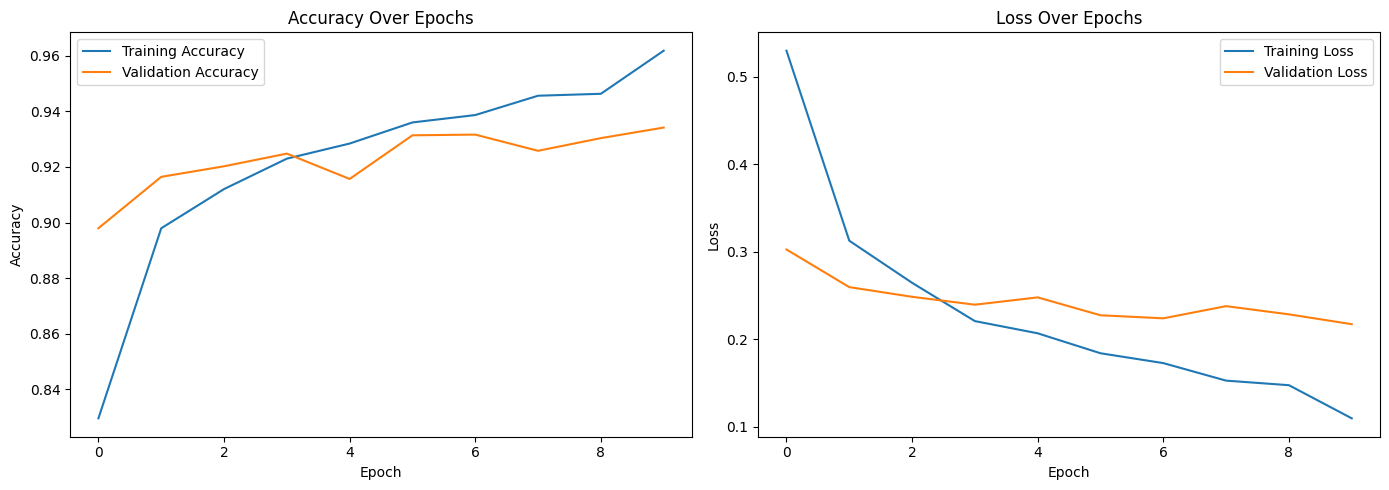

✅ Training curves plotted
124/124 ━━━━━━━━━━━━━━━━━━━━ 95s 737ms/step


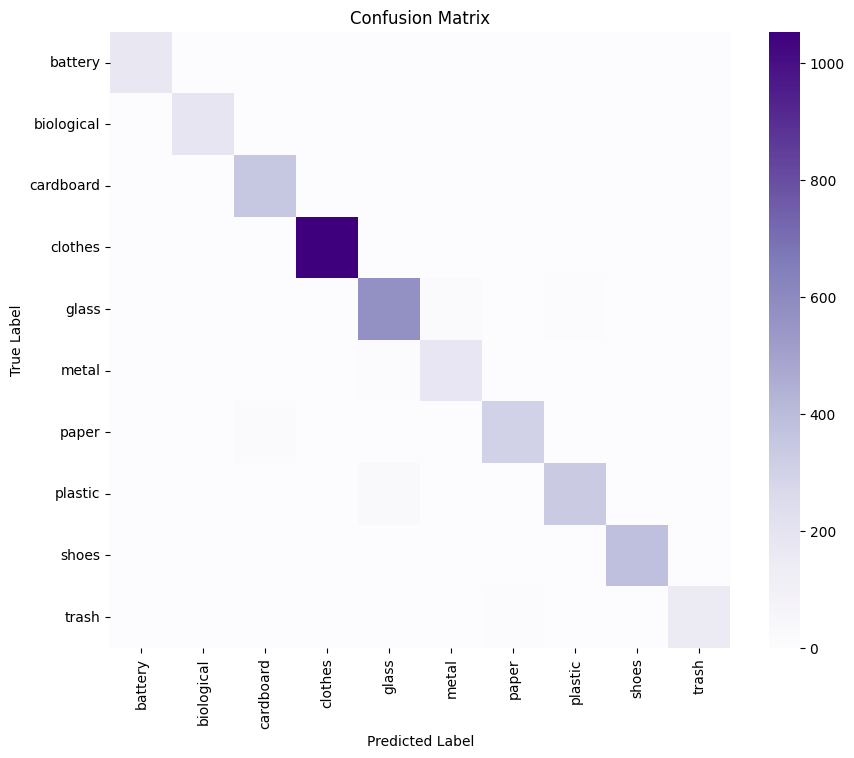

✅ Confusion matrix plotted
📊 Classification Report:

              precision    recall  f1-score   support

     battery       0.96      0.94      0.95       188
  biological       0.95      0.94      0.95       199
   cardboard       0.91      0.96      0.93       365
     clothes       0.99      0.99      0.99      1065
       glass       0.91      0.94      0.92       612
       metal       0.83      0.87      0.85       204
       paper       0.91      0.90      0.90       336
     plastic       0.92      0.85      0.88       396
       shoes       0.96      0.96      0.96       395
       trash       0.88      0.80      0.84       189

    accuracy                           0.93      3949
   macro avg       0.92      0.91      0.92      3949
weighted avg       0.93      0.93      0.93      3949

✅ Report printed


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Load and preprocess data
data_dir = 'garbage-dataset'
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("✅ Data loading complete")

# 2. Load base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

print("✅ Model created")

# 3. Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("✅ Model compiled")

# 4. Train the model
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=2, factor=0.2, verbose=1)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)
print("✅ Training complete")

# 5. Visualize training curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
print("✅ Training curves plotted")

# 6. Evaluation
val_data.reset()
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_data.classes
labels = list(val_data.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Purples',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print("✅ Confusion matrix plotted")

# Classification report
report = classification_report(y_true, y_pred, target_names=labels)
print("📊 Classification Report:\n")
print(report)
print("✅ Report printed")


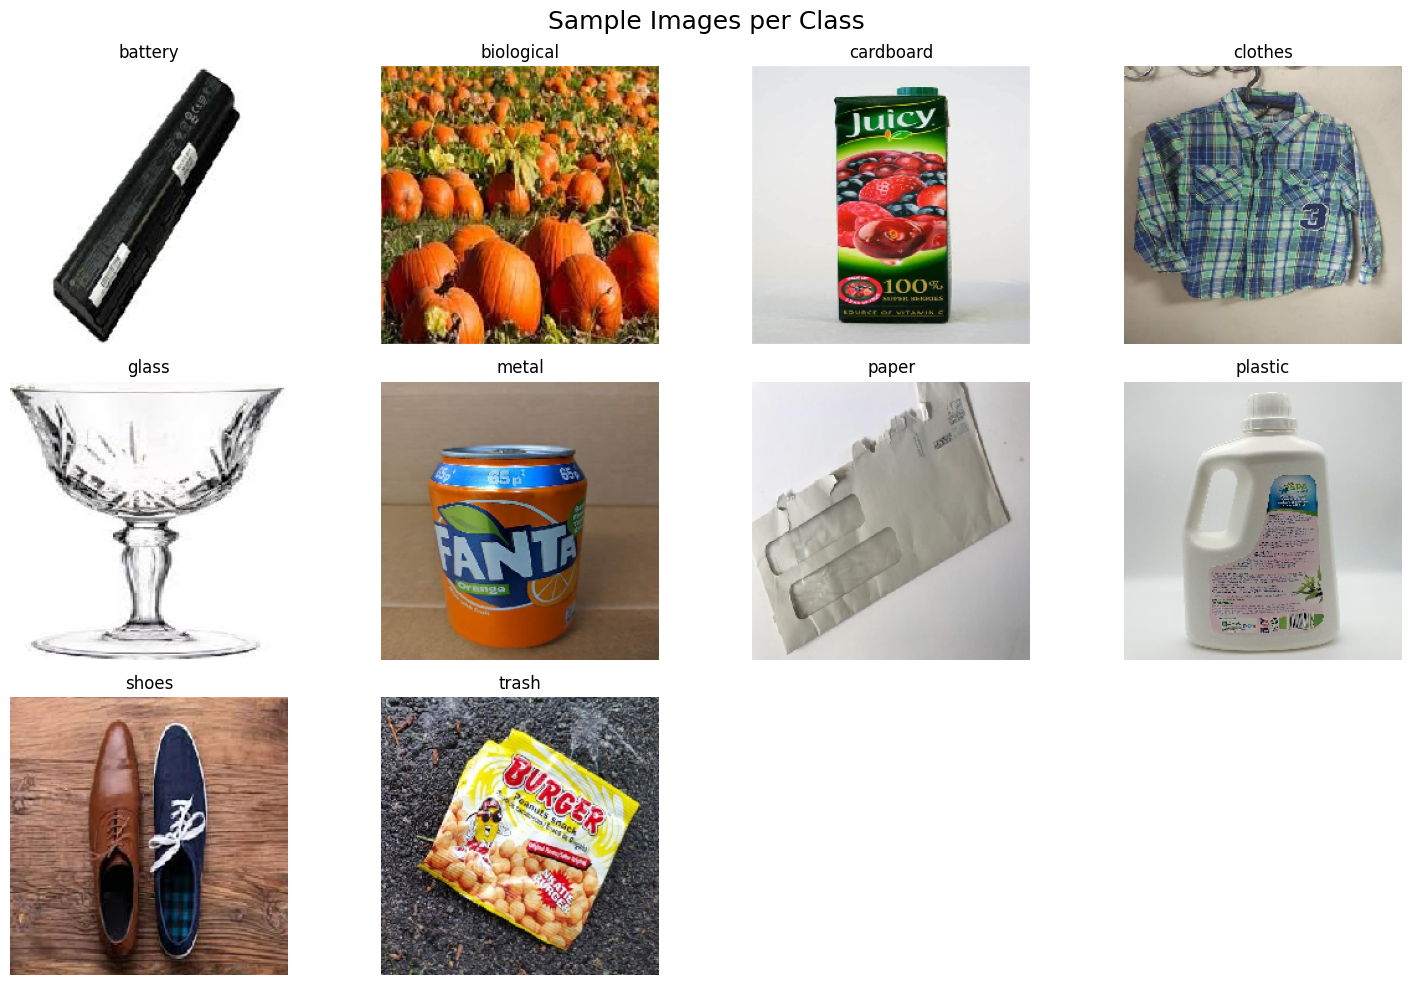

In [3]:
# Visualize sample images per class
import random
class_names = list(train_data.class_indices.keys())
plt.figure(figsize=(15, 10))

for i, class_name in enumerate(class_names):
    folder_path = os.path.join(data_dir, class_name)
    images = os.listdir(folder_path)
    img_path = os.path.join(folder_path, random.choice(images))
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.suptitle("Sample Images per Class", fontsize=18)
plt.tight_layout()
plt.show()


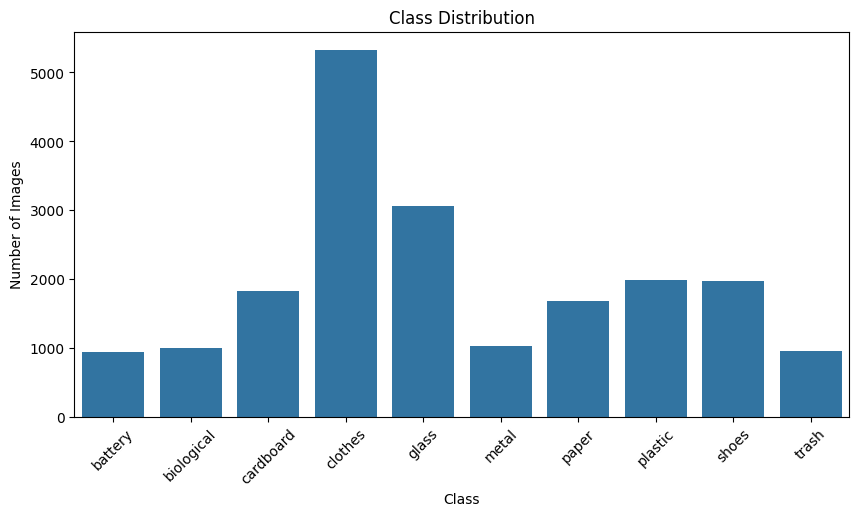

In [4]:
# Count number of images per class
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

# Plot distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


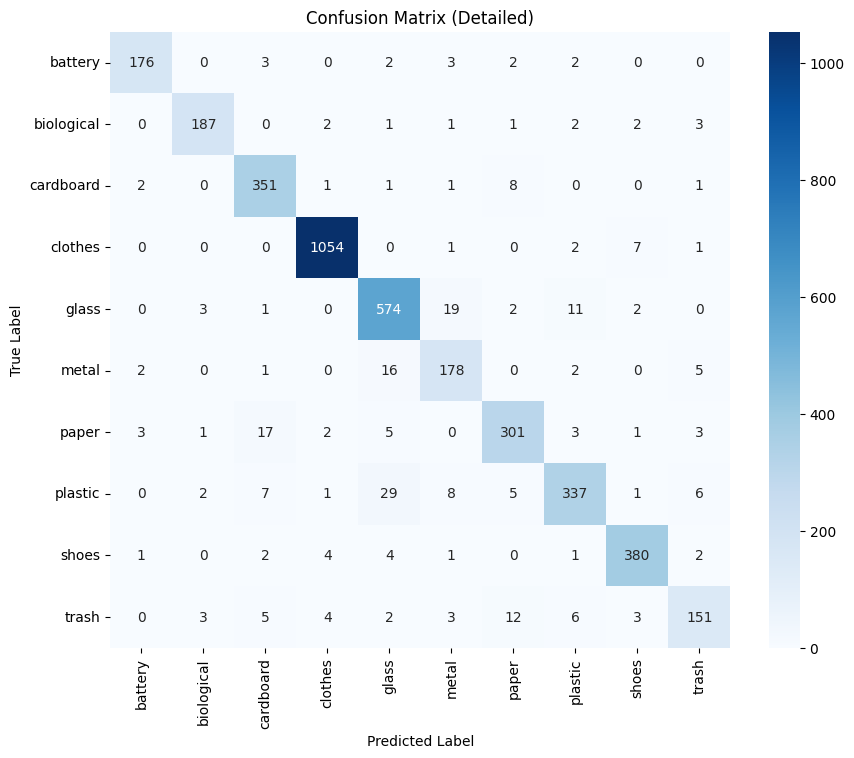

In [5]:
# Better confusion matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Detailed)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


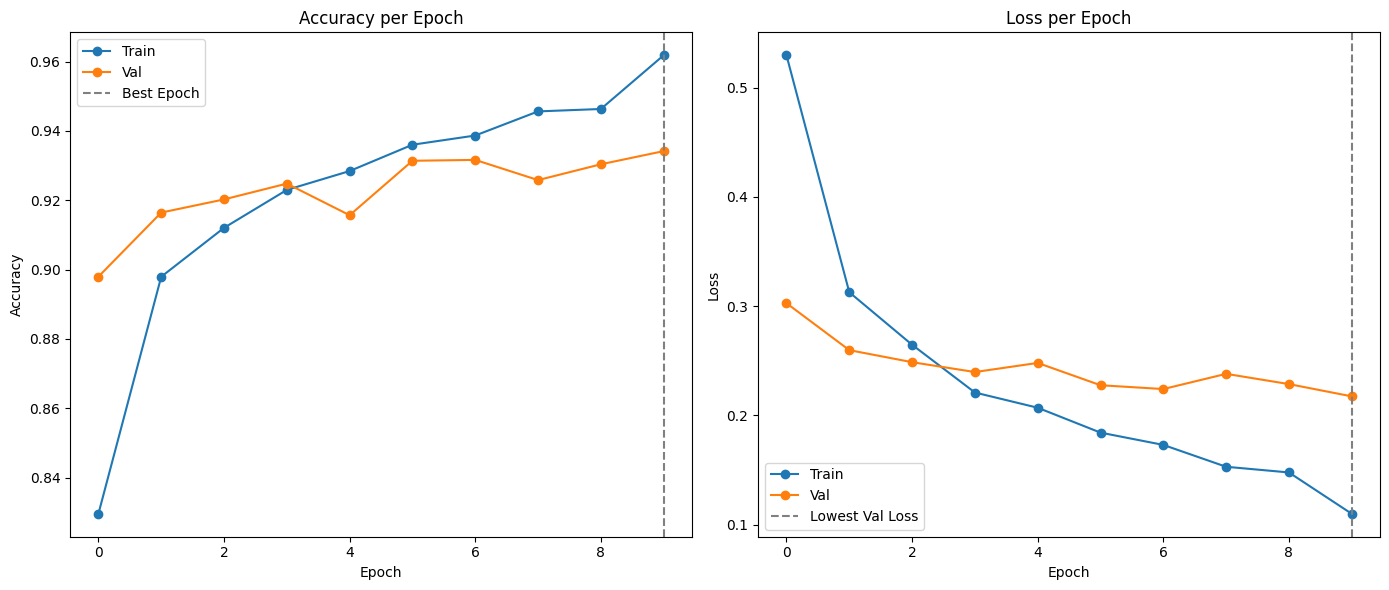

In [6]:
# Enhanced training curves
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train', marker='o')
plt.plot(history.history['val_accuracy'], label='Val', marker='o')
best_epoch = np.argmax(history.history['val_accuracy'])
plt.axvline(best_epoch, linestyle='--', color='gray', label='Best Epoch')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train', marker='o')
plt.plot(history.history['val_loss'], label='Val', marker='o')
best_loss_epoch = np.argmin(history.history['val_loss'])
plt.axvline(best_loss_epoch, linestyle='--', color='gray', label='Lowest Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


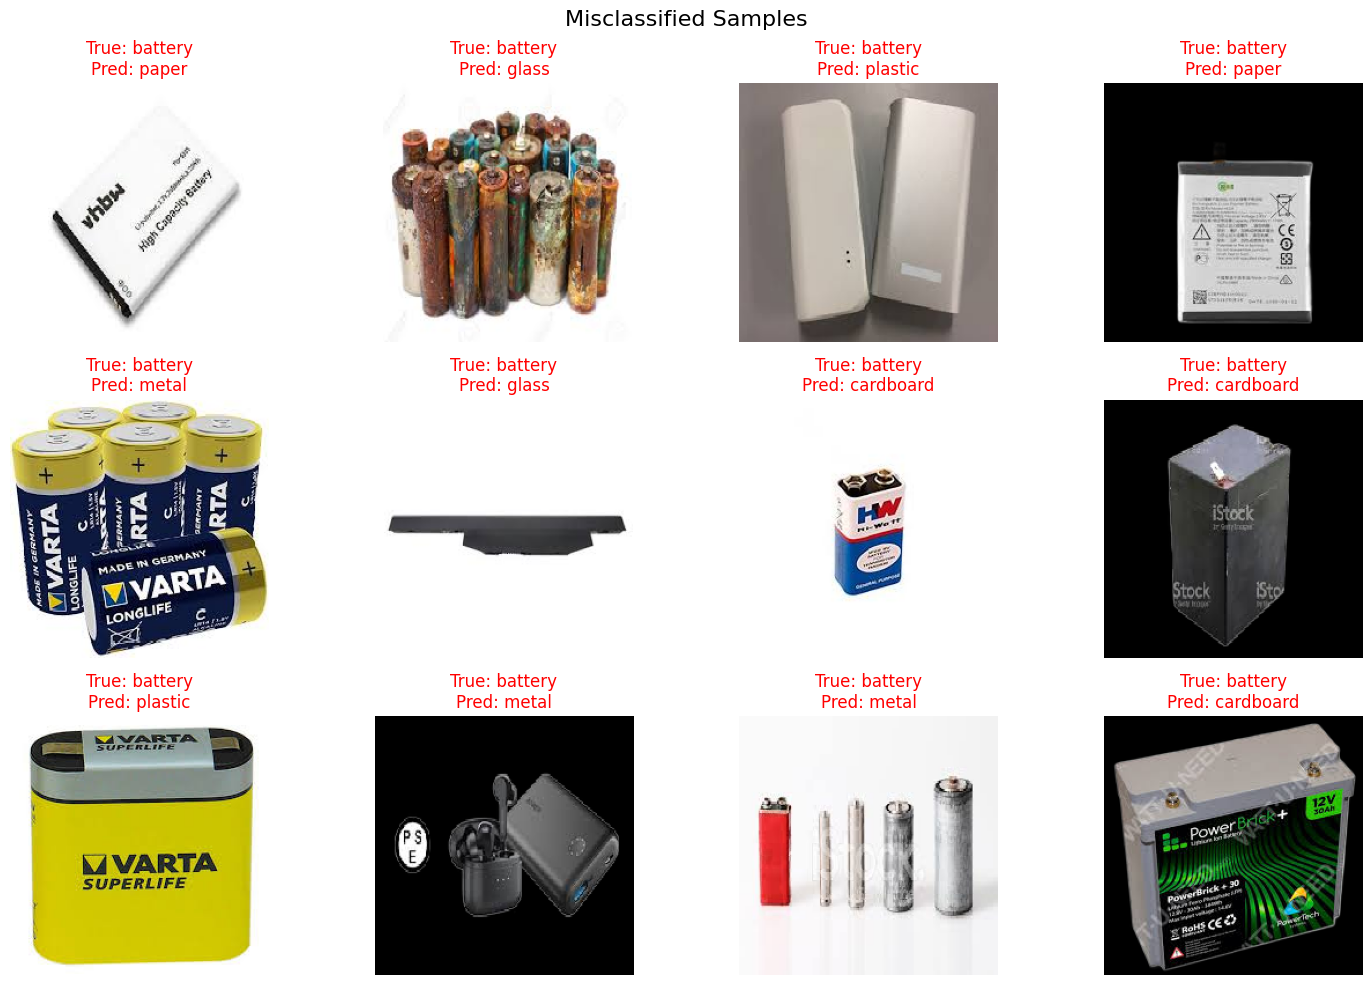

In [9]:
from tensorflow.keras.utils import load_img, img_to_array

# Reset iterator to ensure proper ordering
val_data.reset()

# Find indices of misclassified samples
misclassified_idx = np.where(y_pred != y_true)[0]

# Visualize up to 12 misclassified images
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_idx[:12]):
    # Load image from filepath
    img_path = val_data.filepaths[idx]
    img = load_img(img_path, target_size=img_size)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    true_label = labels[y_true[idx]]
    pred_label = labels[y_pred[idx]]
    plt.title(f"True: {true_label}\nPred: {pred_label}", color='red')
    plt.axis('off')

plt.suptitle("Misclassified Samples", fontsize=16)
plt.tight_layout()
plt.show()


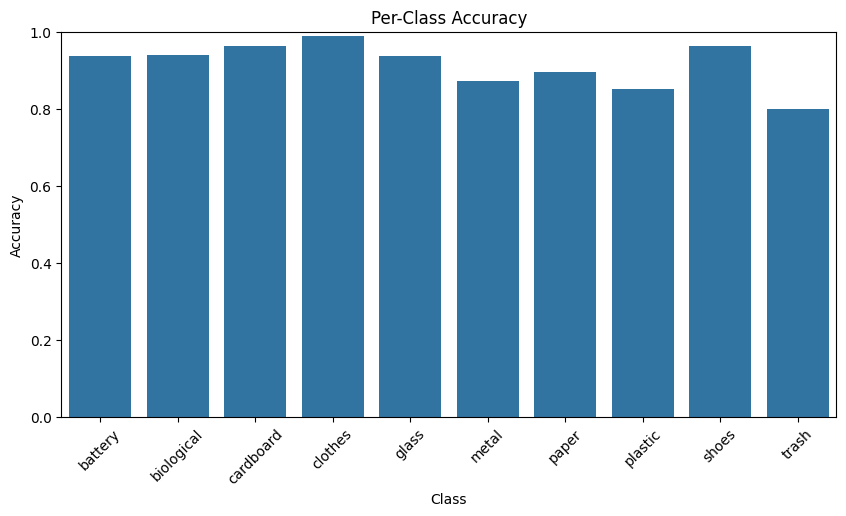

In [8]:
from sklearn.metrics import accuracy_score

# Per class accuracy
per_class_accuracy = {}
for i, label in enumerate(labels):
    idxs = np.where(y_true == i)[0]
    acc = accuracy_score(y_true[idxs], y_pred[idxs])
    per_class_accuracy[label] = acc

plt.figure(figsize=(10, 5))
sns.barplot(x=list(per_class_accuracy.keys()), y=list(per_class_accuracy.values()))
plt.title("Per-Class Accuracy")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


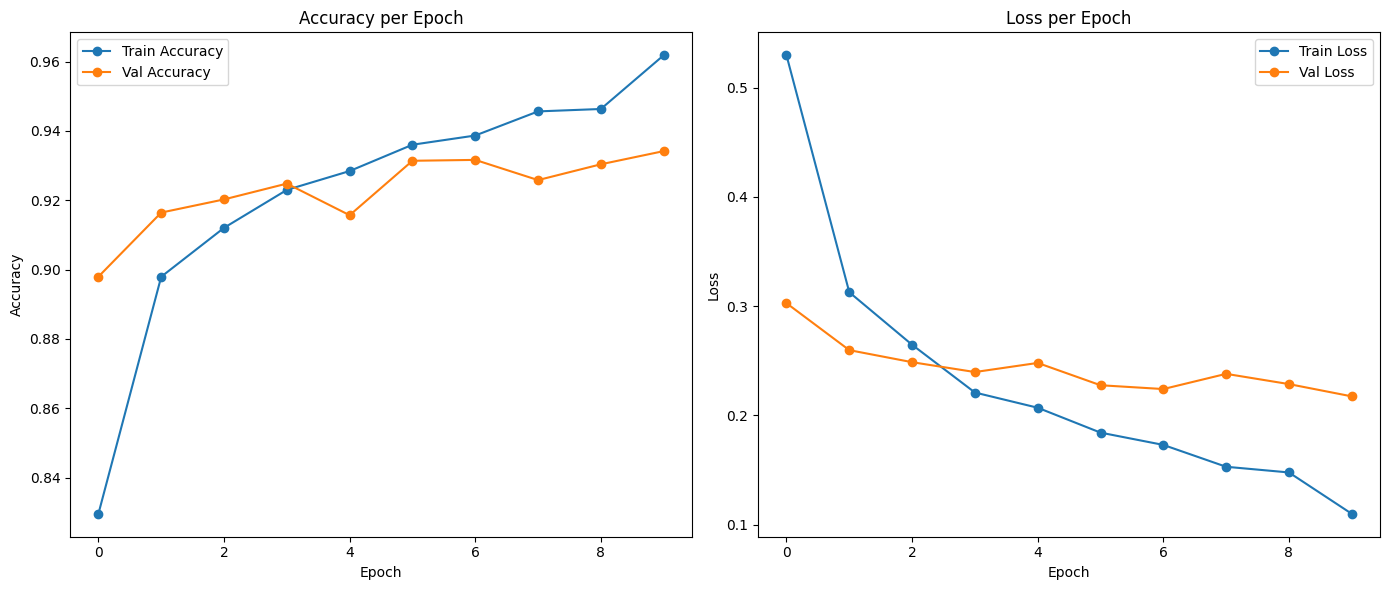

In [10]:
plt.figure(figsize=(14, 6))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


Found 15813 images belonging to 10 classes.
Found 3949 images belonging to 10 classes.
✅ Data loaded
✅ Model built


c:\Users\toqaa\anaconda3\envs\handwrittencharaccter\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 481s 956ms/step - accuracy: 0.6862 - loss: 1.8389 - val_accuracy: 0.7409 - val_loss: 2.0825 - learning_rate: 0.0010
Epoch 2/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 762s 2s/step - accuracy: 0.8680 - loss: 0.6602 - val_accuracy: 0.8015 - val_loss: 1.4365 - learning_rate: 0.0010
Epoch 3/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/step - accuracy: 0.8980 - loss: 0.4738 - val_accuracy: 0.8995 - val_loss: 0.6273 - learning_rate: 0.0010
Epoch 4/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 668s 1s/step - accuracy: 0.9121 - loss: 0.4039 - val_accuracy: 0.8797 - val_loss: 0.6766 - learning_rate: 0.0010
Epoch 5/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9193 - loss: 0.3876
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
495/495 ━━━━━━━━━━━━━━━━━━━━ 1423s 3s/step - accuracy: 0.9193 - loss: 0.3876 - val_accuracy: 0.8797 - val_loss: 0.7691 - learning_rate: 0.0010
Epoch 6/20
495/495 ━━━━━━━━━━━━━━━━━━━━ 559s 1s/step - accuracy: 0.9462 - loss: 0

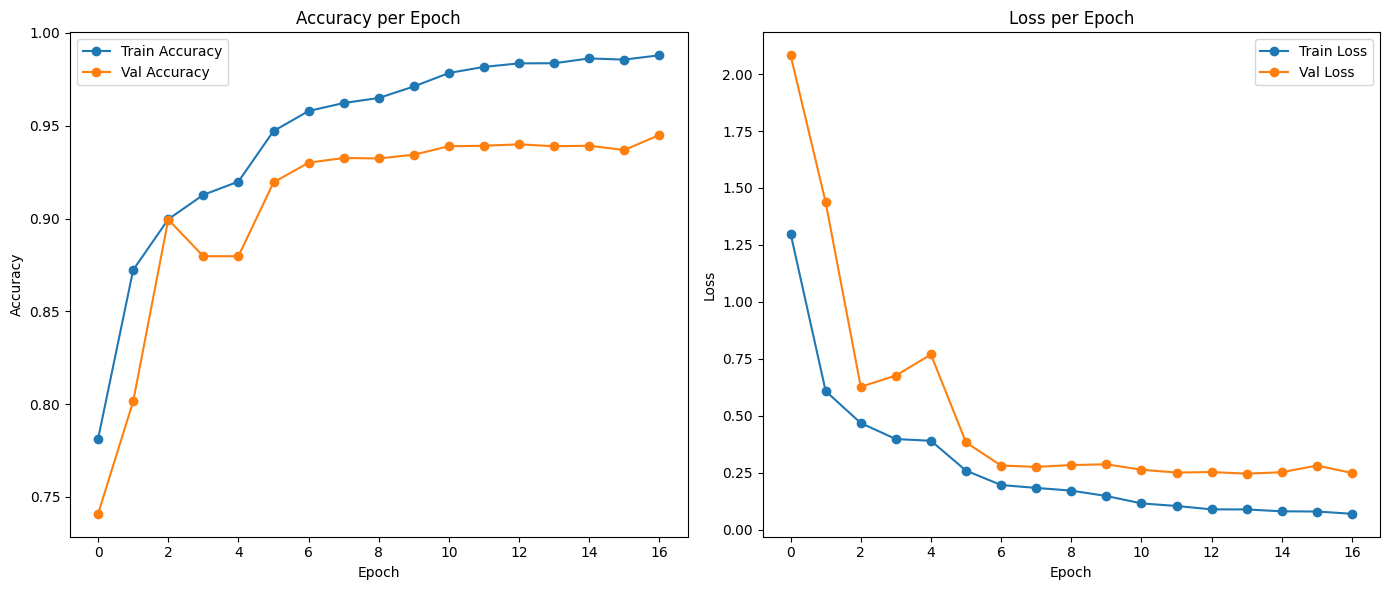

124/124 ━━━━━━━━━━━━━━━━━━━━ 84s 670ms/step


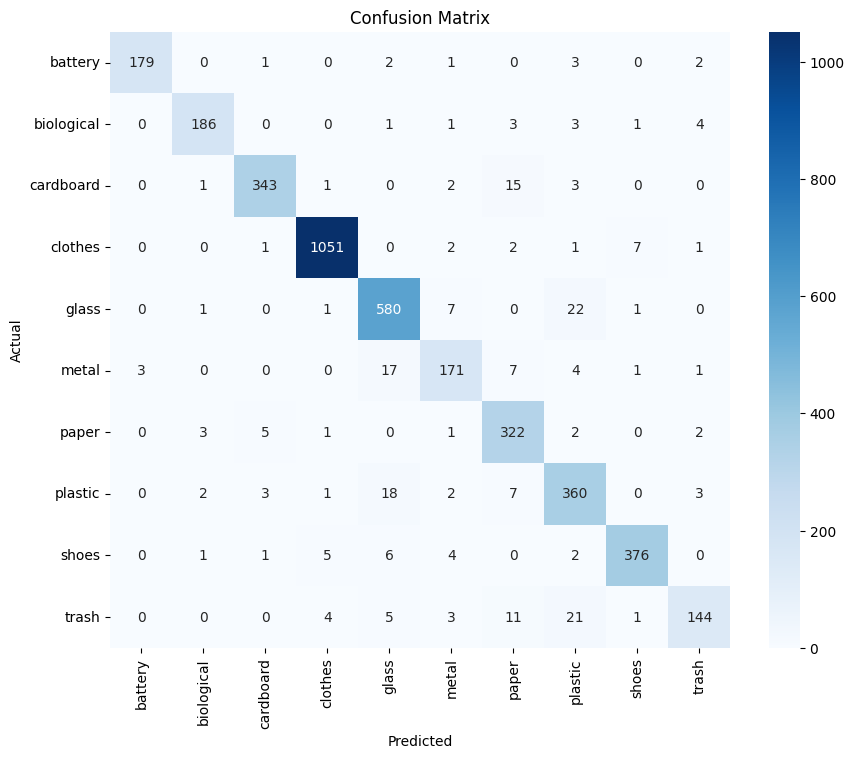

📊 Classification Report:

              precision    recall  f1-score   support

     battery       0.98      0.95      0.97       188
  biological       0.96      0.93      0.95       199
   cardboard       0.97      0.94      0.95       365
     clothes       0.99      0.99      0.99      1065
       glass       0.92      0.95      0.93       612
       metal       0.88      0.84      0.86       204
       paper       0.88      0.96      0.92       336
     plastic       0.86      0.91      0.88       396
       shoes       0.97      0.95      0.96       395
       trash       0.92      0.76      0.83       189

    accuracy                           0.94      3949
   macro avg       0.93      0.92      0.92      3949
weighted avg       0.94      0.94      0.94      3949



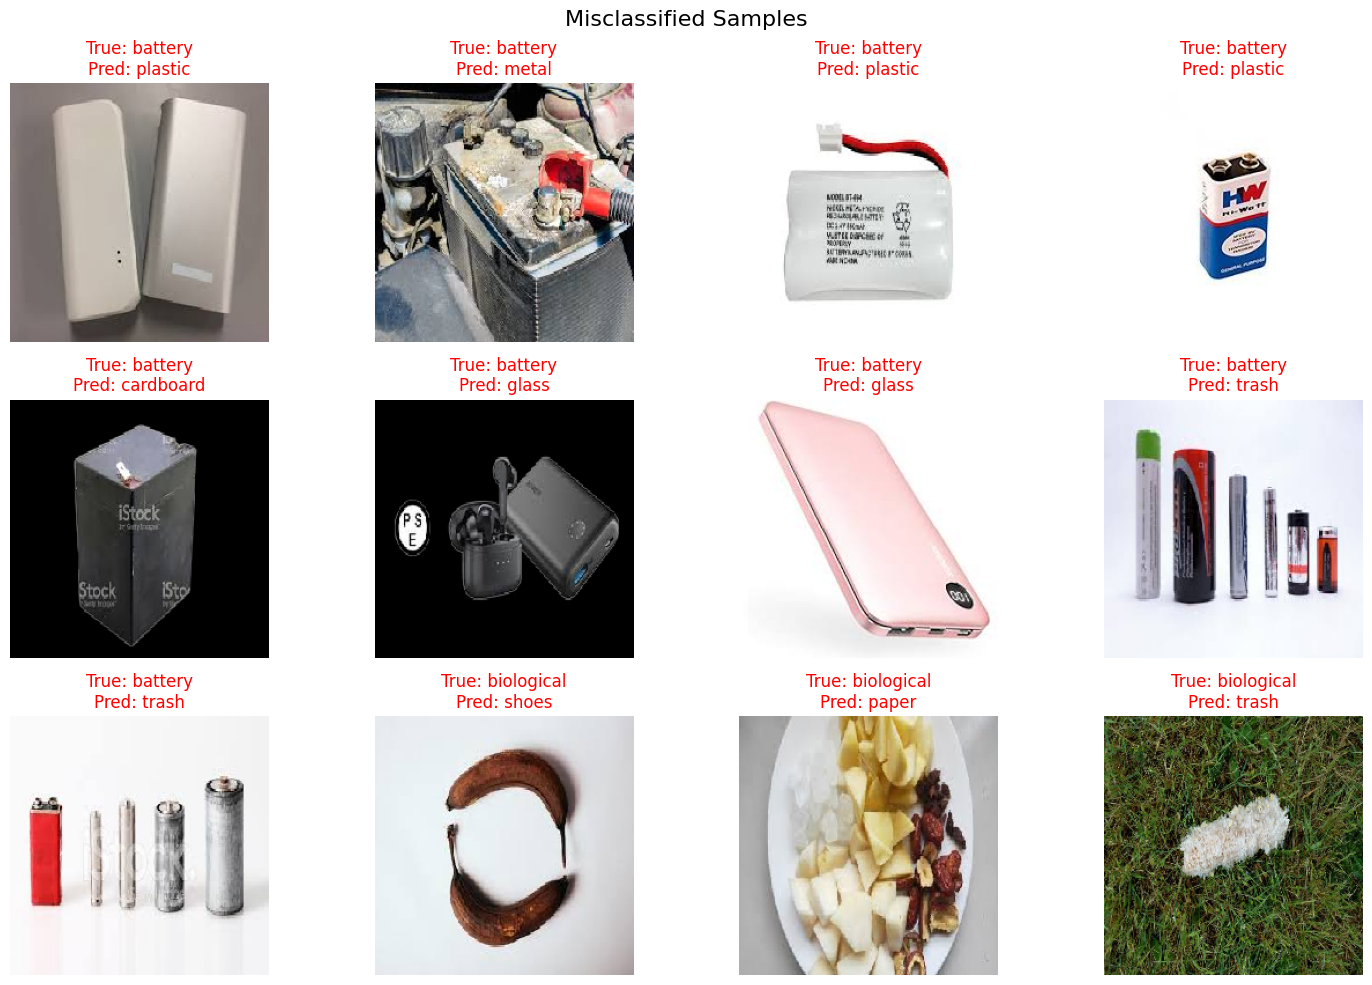

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import load_img

# 1. Load and visualize data
data_dir = 'garbage-dataset'
img_size = (224, 224)
batch_size = 32

# Augmented Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.2,
    shear_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

labels = list(train_data.class_indices.keys())
print("✅ Data loaded")

# 2. Base Model with partial fine-tuning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Custom Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

print("✅ Model built")

# 3. Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.3, verbose=1)

# 5. Train
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

# 6. Plot training vs validation
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 7. Evaluation
val_data.reset()
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_data.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# 8. Misclassified images
misclassified_idx = np.where(y_pred != y_true)[0]
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_idx[:12]):
    img_path = val_data.filepaths[idx]
    img = load_img(img_path, target_size=img_size)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {labels[y_true[idx]]}\nPred: {labels[y_pred[idx]]}", color='red')
    plt.axis('off')
plt.suptitle("Misclassified Samples", fontsize=16)
plt.tight_layout()
plt.show()


In [12]:
# Save model in HDF5 format
model.save("garbage_classifier_model.h5")
print("✅ Model saved as 'garbage_classifier_model.h5'")


✅ Model saved as 'garbage_classifier_model.h5'


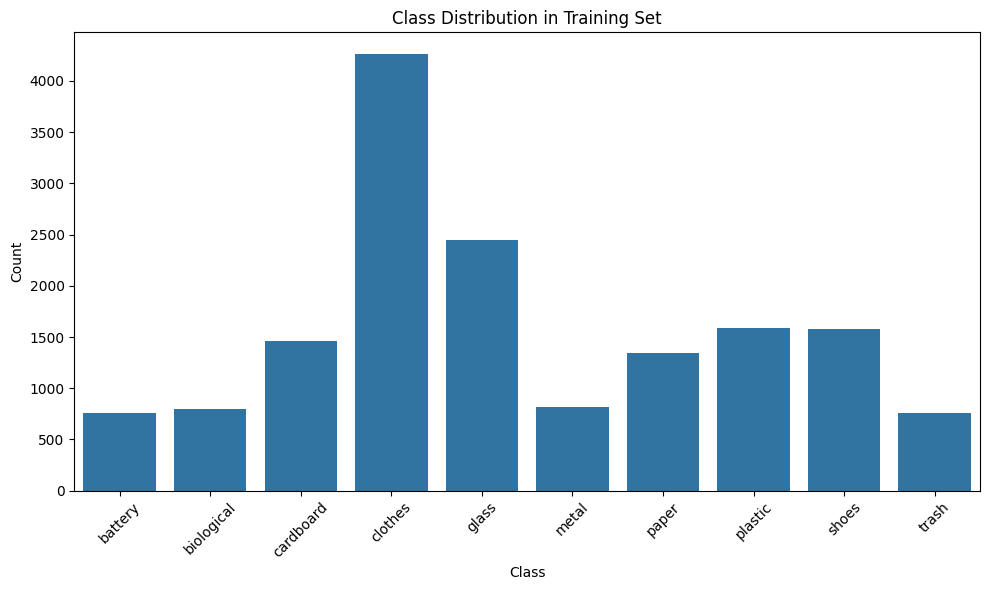

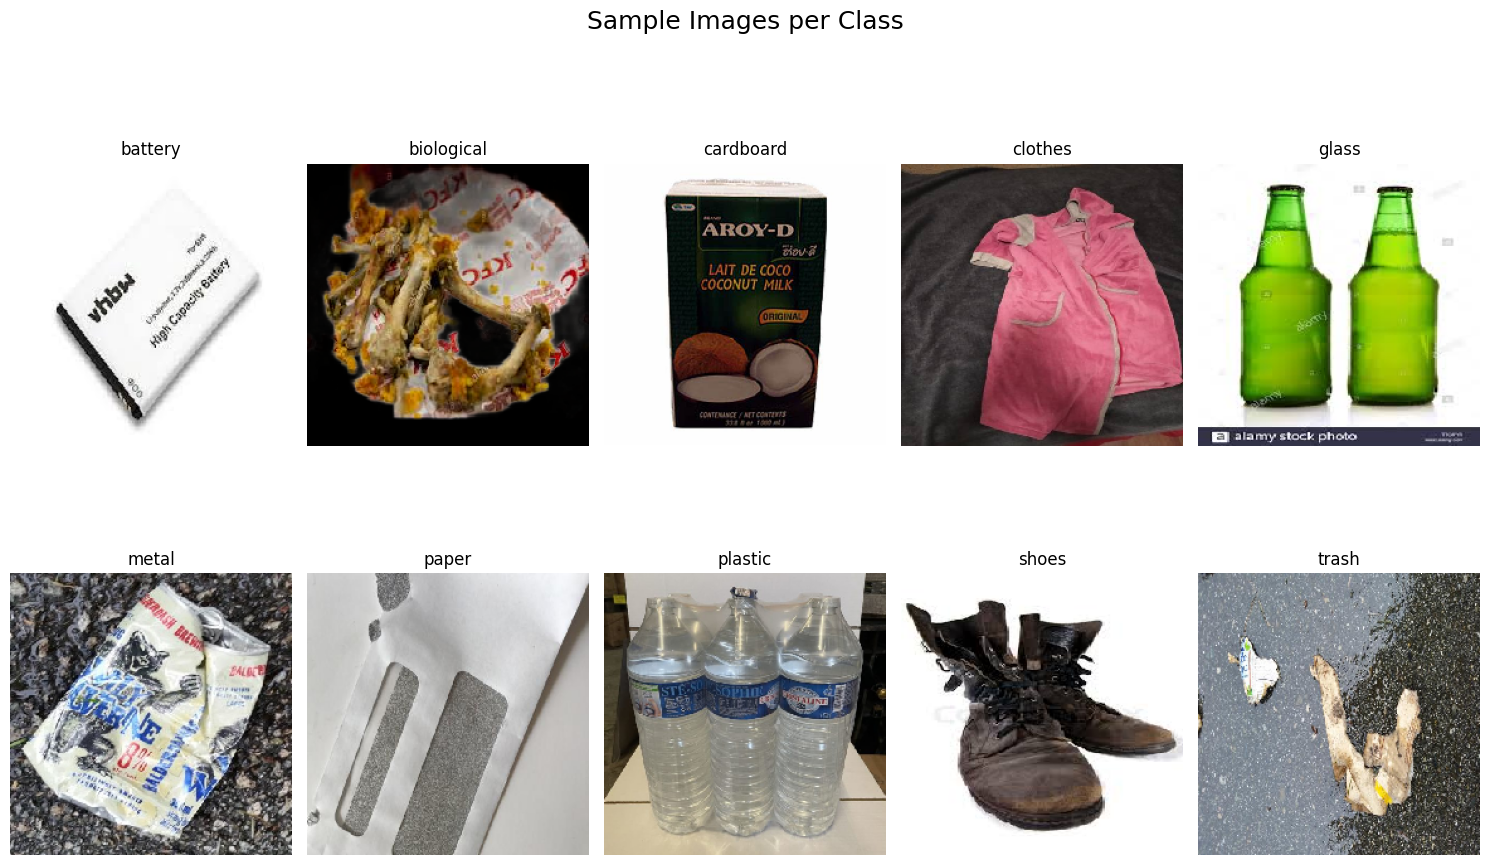

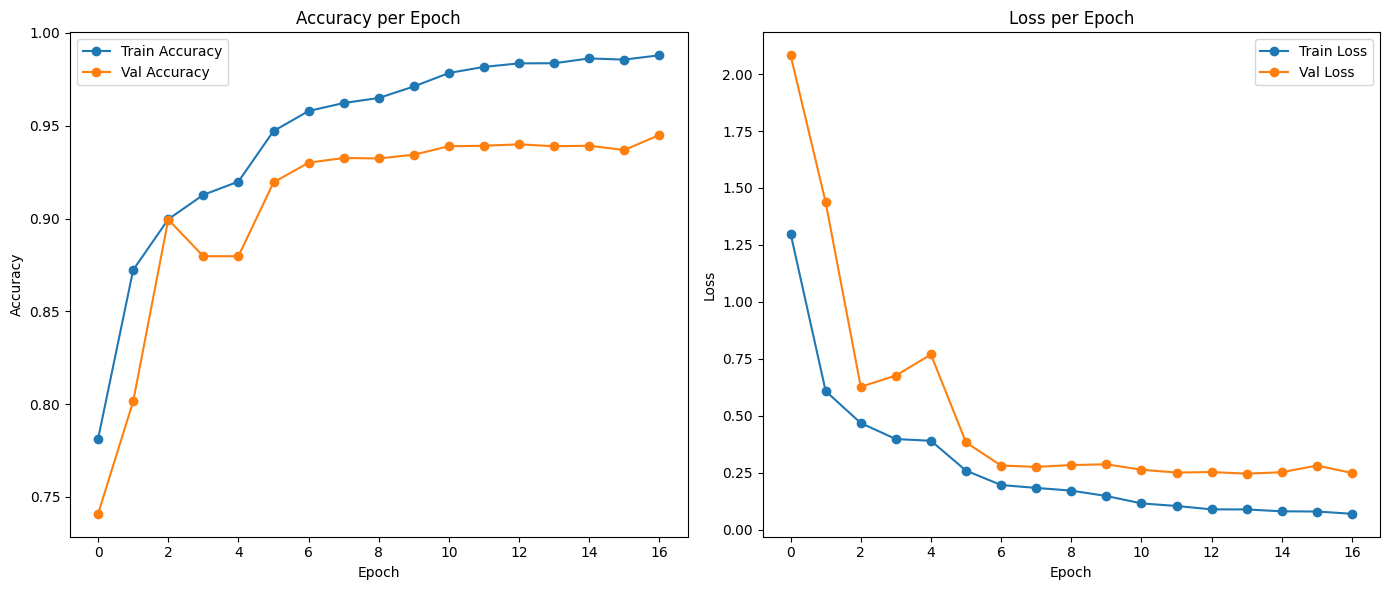

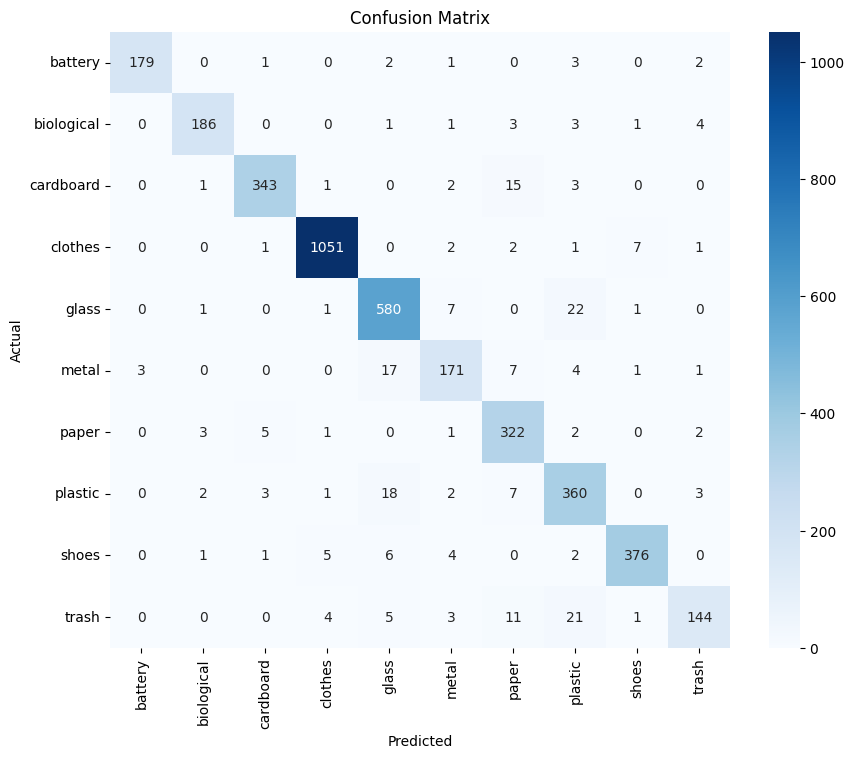

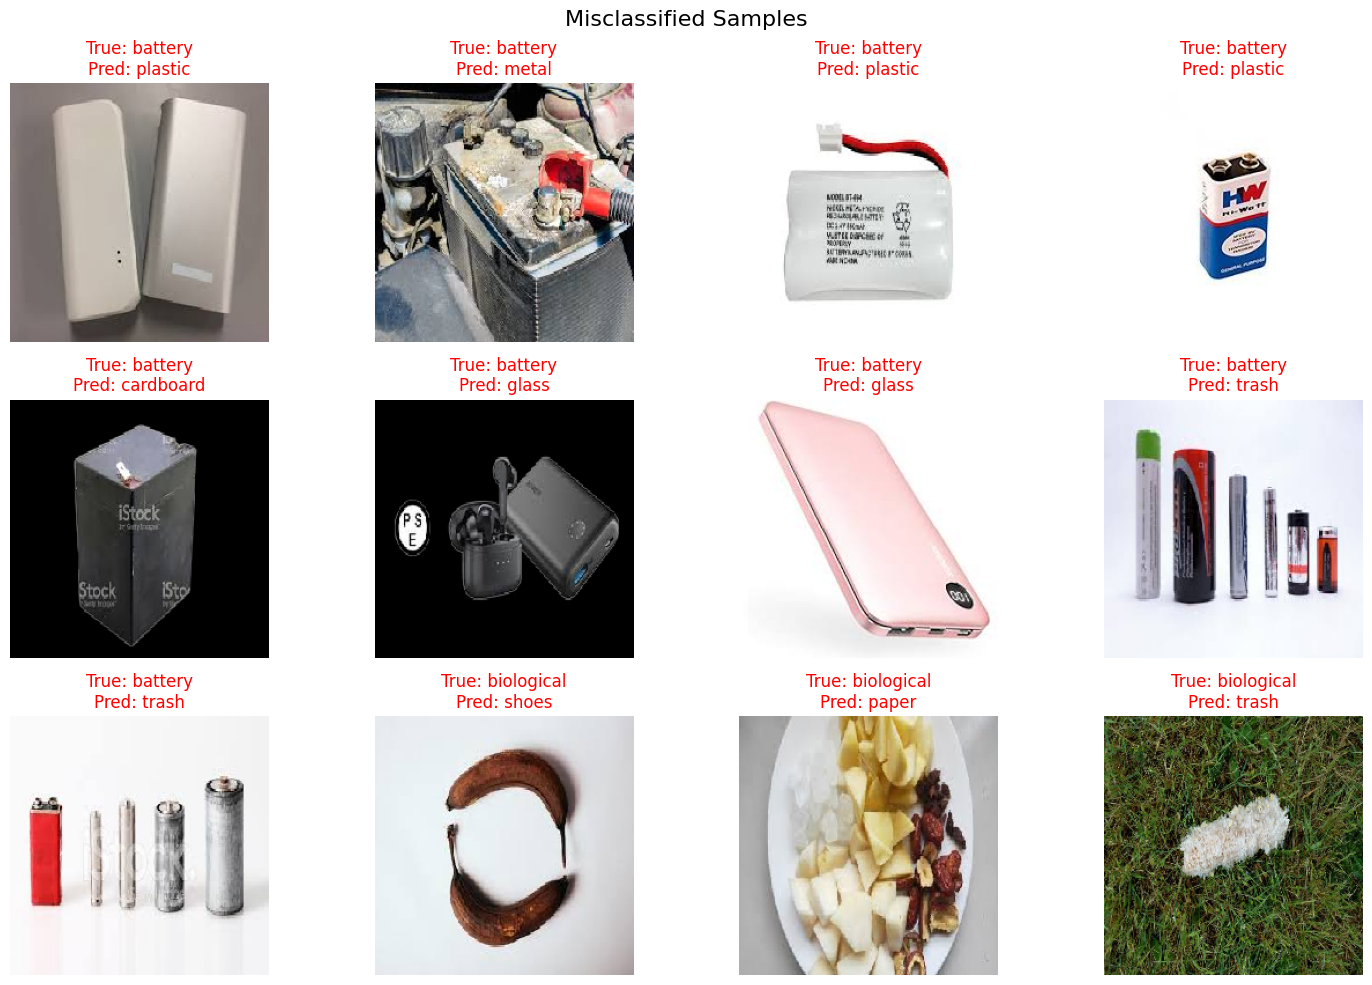

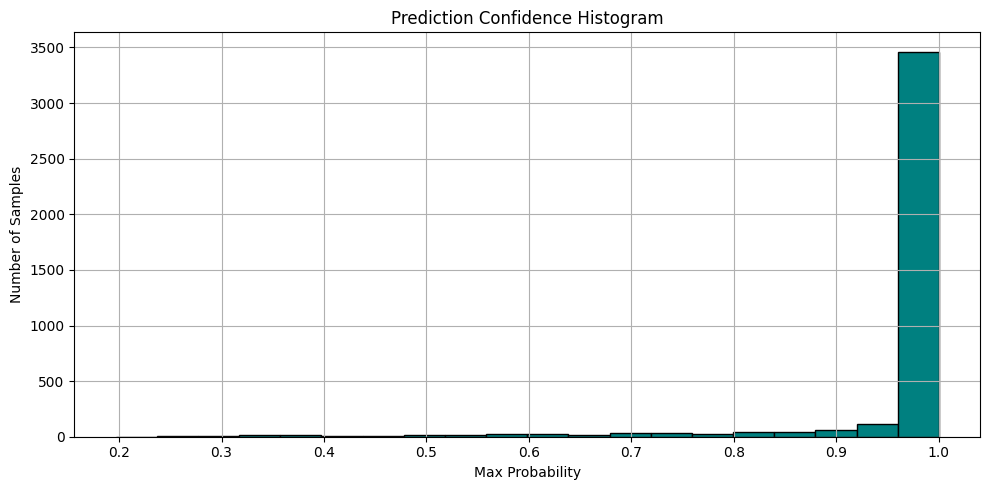

124/124 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step


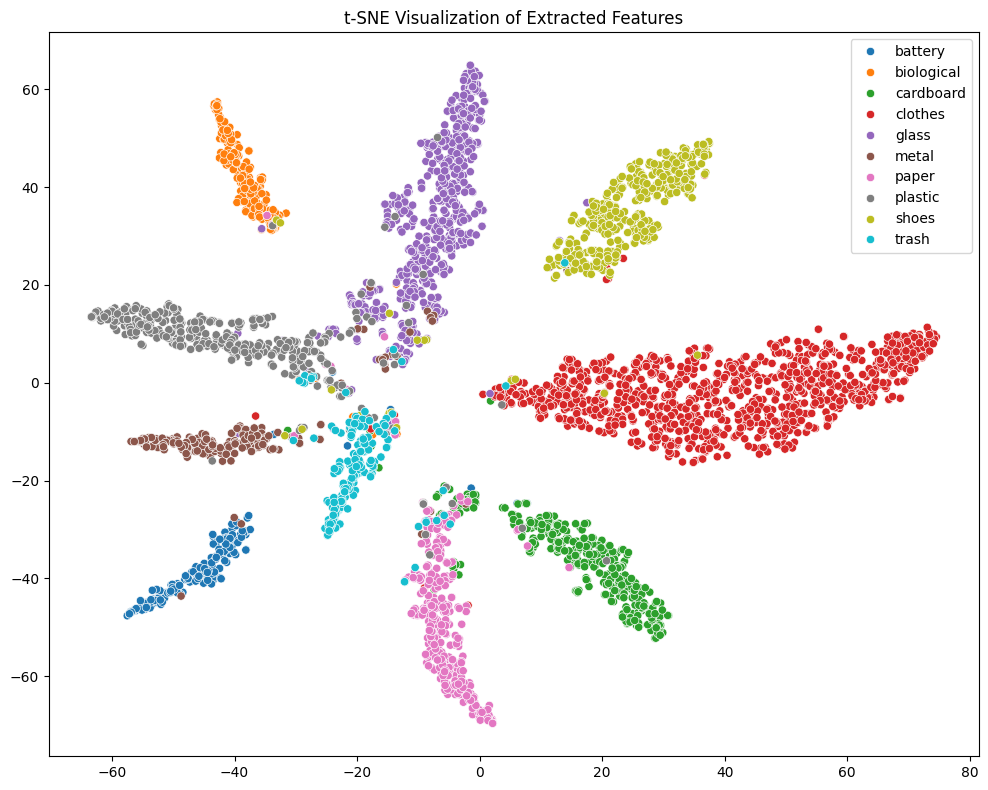

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from tensorflow.keras.utils import load_img
from tensorflow.keras.models import Model

# افترض أن لديك المتغيرات التالية جاهزة:
# - train_data
# - val_data
# - history
# - y_true, y_pred, y_pred_probs
# - labels
# - model
# - data_dir, img_size

# 1️⃣ توزيع الصور في كل كلاس
train_counts = dict(Counter(train_data.classes))
plt.figure(figsize=(10, 6))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2️⃣ عرض صورة واحدة من كل كلاس
plt.figure(figsize=(15, 10))
for idx, label in enumerate(labels[:10]):
    folder = os.path.join(data_dir, label)
    img_path = os.path.join(folder, os.listdir(folder)[0])
    img = load_img(img_path, target_size=img_size)
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.suptitle("Sample Images per Class", fontsize=18)
plt.tight_layout()
plt.show()

# 3️⃣ رسم Accuracy و Loss لكل Epoch
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 4️⃣ رسم مصفوفة الارتباك (Confusion Matrix)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 5️⃣ عرض الصور التي تم تصنيفها بشكل خاطئ
misclassified_idx = np.where(y_pred != y_true)[0]
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_idx[:12]):
    img_path = val_data.filepaths[idx]
    img = load_img(img_path, target_size=img_size)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {labels[y_true[idx]]}\nPred: {labels[y_pred[idx]]}", color='red')
    plt.axis('off')
plt.suptitle("Misclassified Samples", fontsize=16)
plt.tight_layout()
plt.show()

# 6️⃣ Histogram لثقة النموذج في التنبؤات
probs_max = np.max(y_pred_probs, axis=1)
plt.figure(figsize=(10, 5))
plt.hist(probs_max, bins=20, color='teal', edgecolor='black')
plt.title("Prediction Confidence Histogram")
plt.xlabel("Max Probability")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7️⃣ t-SNE لتصور الفضاء المميز Features
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
features = feature_extractor.predict(val_data)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=[labels[i] for i in y_true], palette='tab10')
plt.title("t-SNE Visualization of Extracted Features")
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


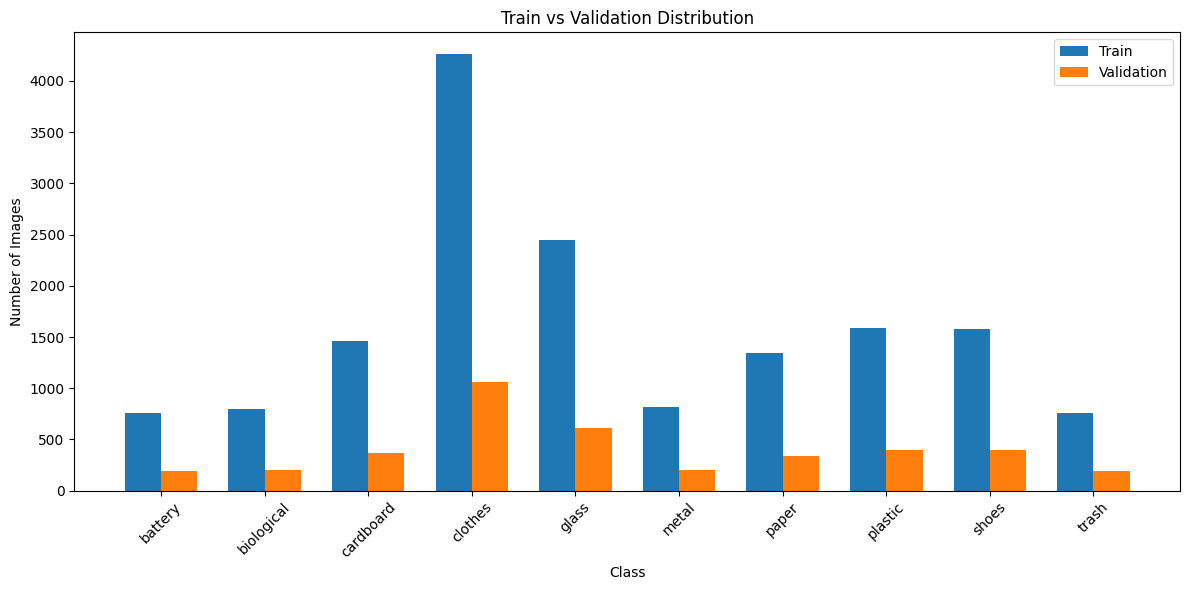

In [14]:
train_counts = dict(Counter(train_data.classes))
val_counts = dict(Counter(val_data.classes))

plt.figure(figsize=(12, 6))
x = np.arange(len(labels))
width = 0.35
plt.bar(x - width/2, [train_counts[i] for i in range(len(labels))], width, label='Train')
plt.bar(x + width/2, [val_counts[i] for i in range(len(labels))], width, label='Validation')
plt.xticks(x, labels, rotation=45)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Train vs Validation Distribution")
plt.legend()
plt.tight_layout()
plt.show()


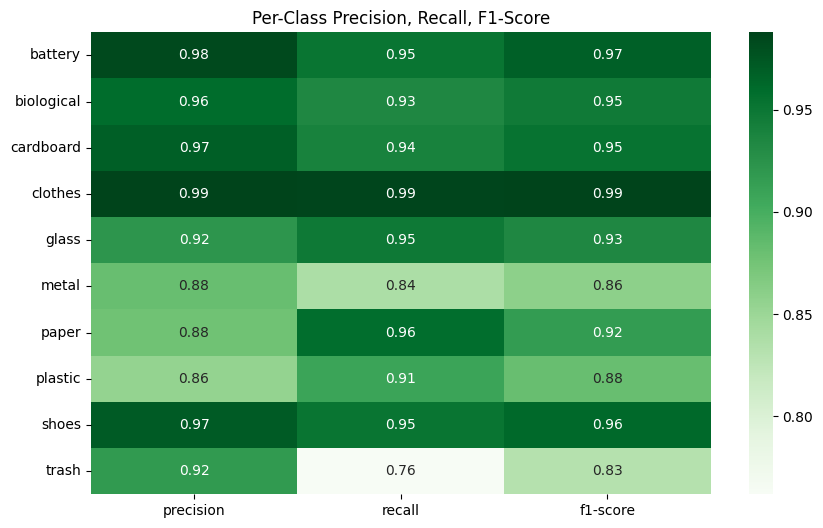

In [15]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
df_report = pd.DataFrame(report).transpose().iloc[:-3, :3]  # فقط per-class
plt.figure(figsize=(10, 6))
sns.heatmap(df_report, annot=True, cmap='Greens', fmt=".2f")
plt.title("Per-Class Precision, Recall, F1-Score")
plt.show()


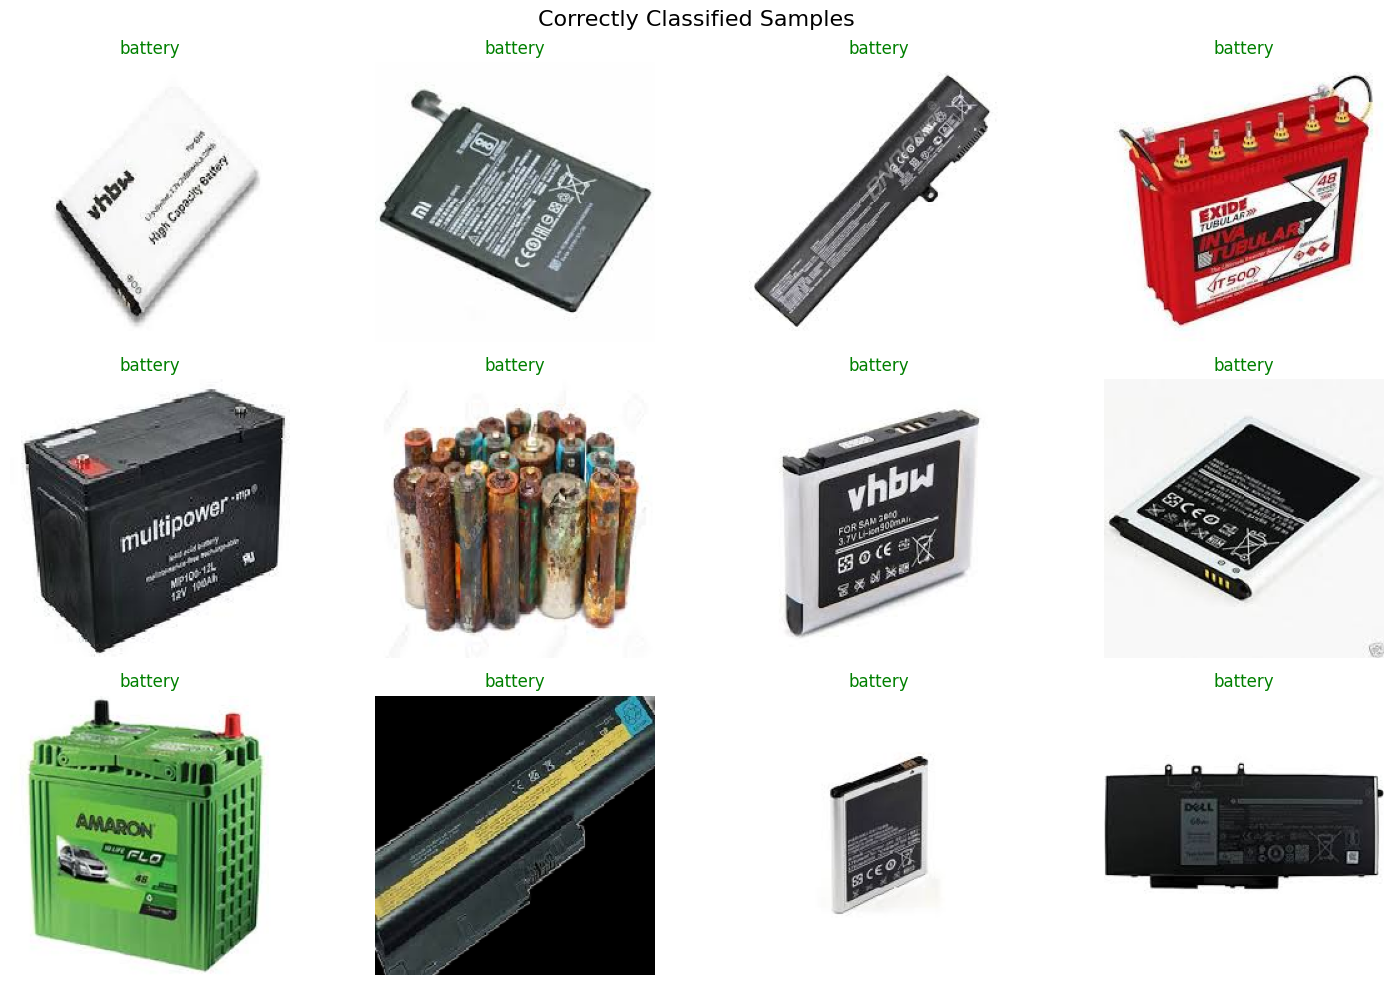

In [16]:
correct_idx = np.where(y_pred == y_true)[0]
plt.figure(figsize=(15, 10))
for i, idx in enumerate(correct_idx[:12]):
    img_path = val_data.filepaths[idx]
    img = load_img(img_path, target_size=img_size)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"{labels[y_true[idx]]}", color='green')
    plt.axis('off')
plt.suptitle("Correctly Classified Samples", fontsize=16)
plt.tight_layout()
plt.show()


In [18]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model_structure.png", show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


124/124 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step


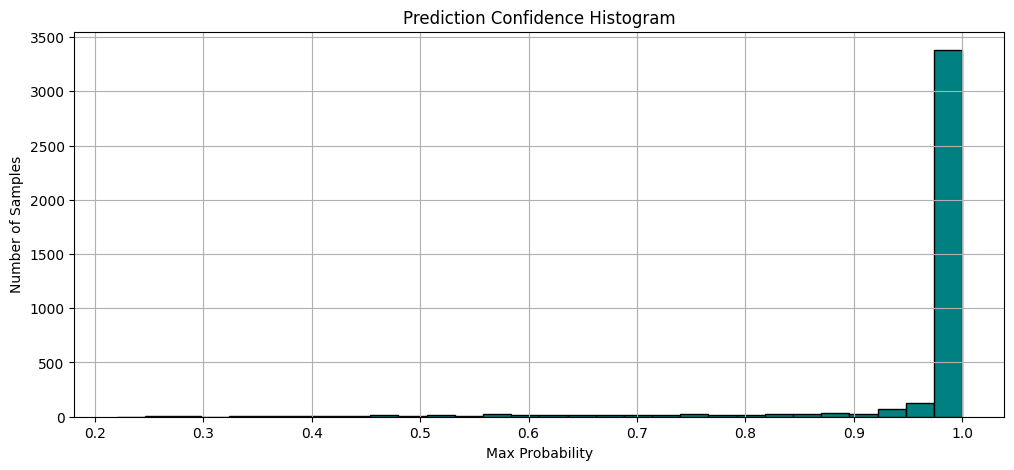

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Predict class probabilities on validation data
y_pred_probs = model.predict(val_data, verbose=1)  # shape = (num_samples, 10)

# Step 2: Extract max probability per sample (prediction confidence)
confidences = np.max(y_pred_probs, axis=1)  # shape = (num_samples,)

# Step 3: Plot histogram
plt.figure(figsize=(12, 5))
plt.hist(confidences, bins=30, color='teal', edgecolor='black')
plt.title("Prediction Confidence Histogram")
plt.xlabel("Max Probability")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()
